# 1. Set Up Notebook and Load Data 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import fnmatch
import pickle
import ipywidgets as widgets
from IPython.display import display
import sys
import os
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Input, Flatten, Dense, Conv2DTranspose, Conv3D, Conv3DTranspose, LeakyReLU, BatchNormalization,  LeakyReLU,  Activation, LSTM, TimeDistributed, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import elu
from tensorflow.keras.initializers import HeUniform, GlorotUniform, HeNormal, LecunNormal
from keras.regularizers import l2, l1, Regularizer



# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.0


Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

In [3]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*24*minmax*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist3D-Full-nE16-nt24-ndt16-normminmax.pkl',), value='hist3D-Ful…

In [11]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
# Data
df_label = df_properties.copy()
ID = df_label['obsreg_id'].values
X = features
# x = np.expand_dims(X, axis=-1)
rs = 505
splits = 0.1
X_train, X_test, ID_train, ID_test = train_test_split(X, ID, test_size=splits, random_state=rs)
# x_train = np.expand_dims(X_train, axis=-1)
# x_test = np.expand_dims(X, axis=-1)
# Print Summary
print ('Training Set', X_train.shape)
print ('Test Set', X_test.shape)
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))


Training Set (85925, 24, 16, 16)
Test Set (9548, 24, 16, 16)
Number of Features:  95473
Number of Property Sets:  95473


# 3. Automodel Model

In [14]:
#Settings
input_shape = (24,16,16,1)
in1 = 24
in2 = 16
in3 = 16
cnn_layers = [4,8]
fc_layers = [384, 128]
bottleneck = 32
n_cnn = len(cnn_layers)
cnn_reduce = 2 ** n_cnn
activation = LeakyReLU(alpha=0.05) # 'relu'# 'selu' #LeakyReLU(alpha=0.1) #'relu' #LeakyReLU(alpha=0.1) #'relu' #LeakyReLU(alpha=0.2) # 'selu' # LeakyReLU(alpha=0.2)
kernel_init = 'he_uniform' #HeUniform(seed=505) # LecunNormal(seed=42) #  #'he_normal' # # #'glorot_uniform'# 'he_normal' #'glorot_uniform' #'he_normal' #'glorot_uniform'
lr = 0.001
epochs = 30
batch = 512
# Define encoder
model = Sequential()
model.add(Lambda(lambda x: x, input_shape=input_shape))
for cnn in cnn_layers:
    model.add(Conv3D(cnn, (3, 3, 3), activation=activation, kernel_initializer= kernel_init, padding='same'))
    # model.add(BatchNormalization())
    model.add(Conv3D(cnn, (2, 2, 2), strides = 2, activation=activation, kernel_initializer= kernel_init, padding='same'))
model.add(Flatten())
for fc in fc_layers:
    model.add(Dense(fc, activation=activation, kernel_initializer = kernel_init))
# Define bottleneck
model.add(Dense(bottleneck, activation=activation, kernel_initializer = kernel_init, name='bottleneck'))
# Define decoder
for fc in fc_layers[::-1]:
    model.add(Dense(fc, activation=activation, kernel_initializer = kernel_init))
last_conv_layer_filters = cnn_layers[-1]
reshape_filters = in1 // cnn_reduce * in2 // cnn_reduce * in3 // cnn_reduce * last_conv_layer_filters
model.add(Dense(reshape_filters, activation=activation, kernel_initializer = kernel_init))
model.add(Reshape((in1//cnn_reduce, in2//cnn_reduce, in3//cnn_reduce,cnn_layers[-1])))
for cnn in cnn_layers[::-1]:
    model.add(Conv3D(cnn, (3, 3, 3), activation=activation, kernel_initializer= kernel_init, padding='same'))
    # model.add(BatchNormalization())
    model.add(Conv3DTranspose(cnn, (2, 2, 2), strides = 2, activation=activation, kernel_initializer= kernel_init, padding='same'))
model.add(Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))
# Training Set Up
optimizer = Adam(learning_rate = lr)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
loss_function = 'mse'
model.compile(optimizer=optimizer, loss=loss_function)
model.summary()
# Training 
name = input('Name: ')
print(name)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
bottle_index = model.layers.index(model.get_layer(name='bottleneck'))
print('Depth: ', bottle_index)
history = model.fit(X_train, X_train, epochs=epochs,batch_size=batch,shuffle=True,validation_split=0.2,callbacks=[reduce_lr_callback, early_stopping]) # 128 or 256, 512, 1024, 2048, 4096
encoder_model = Model(inputs=model.input, outputs=model.layers[bottle_index].output)
# Saving
model.save(f'{global_path}/{set_id}/XAE-AUTOENCODER-3D-CNN-cn{cnn_layers}-fc{fc_layers}-neck{bottleneck}-lr{lr}-b{batch}-{name}.h5')
encoder_model.save(f'{global_path}/{set_id}/XAE-ENCODER-3D-CNN-cn{cnn_layers}-fc{fc_layers}-neck{bottleneck}-lr{lr}-b{batch}-{name}.h5')
with open(f'{global_path}/{set_id}/XAE-HISTORY-3D-CNN-cn{cnn_layers}-fc{fc_layers}-neck{bottleneck}-lr{lr}-b{batch}-{name}.pickle', 'wb') as file:
    pickle.dump(history.history, file)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 24, 16, 16, 1)     0         
                                                                 
 conv3d_42 (Conv3D)          (None, 24, 16, 16, 4)     112       
                                                                 
 conv3d_43 (Conv3D)          (None, 12, 8, 8, 4)       132       
                                                                 
 conv3d_44 (Conv3D)          (None, 12, 8, 8, 8)       872       
                                                                 
 conv3d_45 (Conv3D)          (None, 6, 4, 4, 8)        520       
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 dense_30 (Dense)            (None, 384)              

In [6]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')
ac_files = [f for f in files if fnmatch.fnmatch(f, '*-AUTOENCODER*CNN*cn*.h5')]
encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*CNN*cn*h5')]
hist_files = [f for f in files if fnmatch.fnmatch(f, '*-HISTORY*CNN*cn*pickle')]
ac_widget = widgets.Dropdown(options=ac_files[:],value=ac_files[-1],description='Autoencoder :',disabled=False,style = {'description_width': 'initial'}); ac_widget 
hist_widget = widgets.Dropdown(options=hist_files[:],value=hist_files[-1],description='History :',disabled=False,style = {'description_width': 'initial'}); hist_widget 
encode_widget = widgets.Dropdown(options=encode_files[:],value=encode_files[-1],description='Encoder :',disabled=False,style = {'description_width': 'initial'}); encode_widget 
layout = widgets.HBox([ac_widget, hist_widget, encode_widget])
display(layout)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 24, 16, 16, 1)     0         
                                                                 
 conv3d (Conv3D)             (None, 24, 16, 16, 16)    448       
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 8, 8, 16)      2064      
                                                                 
 conv3d_2 (Conv3D)           (None, 12, 8, 8, 8)       3464      
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 4, 4, 8)        520       
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 bottleneck (Dense)          (None, 100)               7

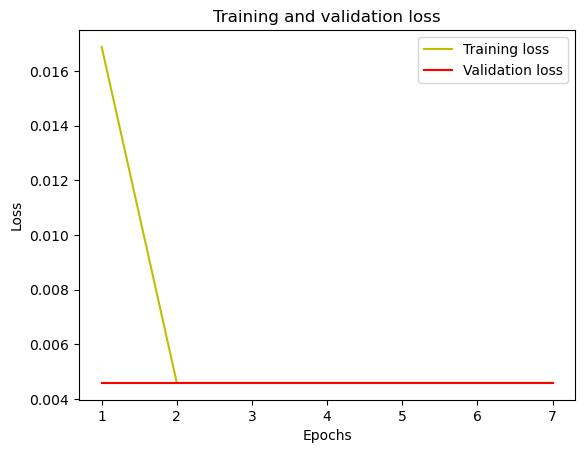

In [7]:
# Load the selected saved model 
ac = ac_widget.value
h = hist_widget.value
e = encode_widget.value
model = tf.keras.models.load_model(f'{global_path}/{set_id}/{ac}')
encoder_model = tf.keras.models.load_model(f'{global_path}/{set_id}/{e}')
model.summary()
encoder_model.summary()
with open(f'{global_path}/{set_id}/{h}', 'rb') as file:
    summary = pickle.load(file)
#plot the training and validation accuracy and loss at each epoch
loss = summary['loss']
val_loss = summary['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
test_loss = model.evaluate(X_test, X_test)
test_recon = model.predict(X_test)
compression_ratio = X_test.shape[1] * X_test.shape[2] / test_recon.shape[1]
# perf = compression_ratio/
# Print the test loss
print(f'Test loss: {test_loss:.4f}') #0.0088 yuri
# print('Compression Ratio: ', compression_ratio)
# print(f'Metric:', )

299/299 [==============================] - 11s 38ms/step
Test loss: 0.0046


In [170]:
reconstructions = model.predict(X)
embedding = encoder_model.predict(X)


2984/2984 [==============================] - 6s 2ms/step


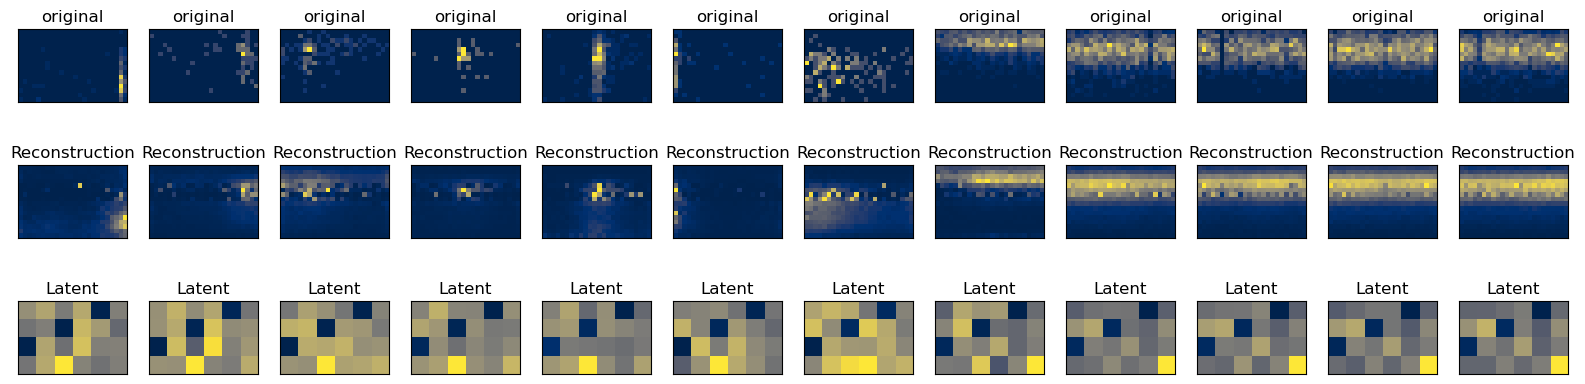

In [171]:
import random
# filtered_ids = [id for id in ids if id.split('_')[1] == '10'][10:20]
#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218']
# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']
# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015
flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']
NEW = ['23022_122']
ran = random.randint(0, 95000)
r = ids[ran:ran+10]
items_to_find = NEW + xue + lin + distefano + parmar 
# items_to_find = r
# Using a list comprehension to find indices of items in the other list
indices = [ids.index(item) for item in items_to_find]

n = len(indices)
plt.figure(figsize=(20, 5))
top = 40
k = 0 

for i in indices:
  k = k+1
  # display original
  ax = plt.subplot(3, n, k)
  plt.imshow(X[i].T,cmap='cividis')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, k+n)
  plt.imshow(reconstructions[i][:,:,0].T,cmap='cividis')
  plt.title(f'Reconstruction')
  # plt.title(f'R: {rec_err[i]:.3f}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display encoded results
  ax = plt.subplot(3, n, k+n+n)
  plt.imshow(embedding[i].reshape((6,4)).T,cmap='cividis')
  plt.title(f'Latent')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

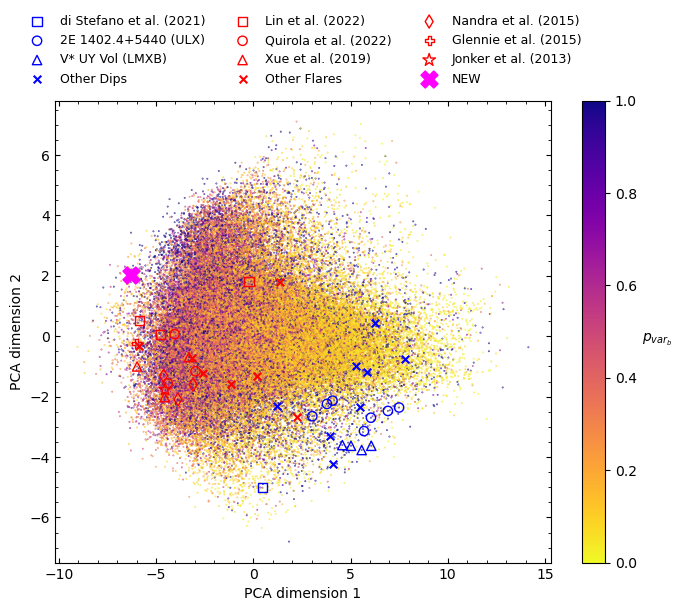

In [172]:
# PCA
from sklearn.preprocessing import StandardScaler
embedding = np.array([np.array(e).flatten() for e in embedding])
scaler = StandardScaler()
normalized_repr = scaler.fit_transform(embedding)


from sklearn.decomposition import PCA
pca_model = PCA(2)
X_pca = pca_model.fit_transform(normalized_repr) 
df_pca = pd.DataFrame(X_pca, columns=['1', '2'])
df_pca['obsreg_id'] = ID


pca_lin = df_pca.loc[df_pca['obsreg_id'].isin(lin)]
pca_irwin = df_pca.loc[df_pca['obsreg_id'].isin(irwin)]
pca_glennie = df_pca.loc[df_pca['obsreg_id'].isin(glennie)]
pca_jonker = df_pca.loc[df_pca['obsreg_id'].isin(jonker)]
pca_vasquez = df_pca.loc[df_pca['obsreg_id'].isin(vasquez)]
pca_xue = df_pca.loc[df_pca['obsreg_id'].isin(xue)]
pca_goulding = df_pca.loc[df_pca['obsreg_id'].isin(goulding)]
pca_nandra = df_pca.loc[df_pca['obsreg_id'].isin(nandra)]
pca_flares = df_pca.loc[df_pca['obsreg_id'].isin(flares + flares_maybe)]

pca_m101ulx = df_pca.loc[df_pca['obsreg_id'].isin(m101ulx)]
pca_distefano = df_pca.loc[df_pca['obsreg_id'].isin(distefano)]
pca_moredips = df_pca.loc[df_pca['obsreg_id'].isin(ieva + dips_maybe)]
pca_parmar = df_pca.loc[df_pca['obsreg_id'].isin(parmar)] # LMXB

pca_new = df_pca.loc[df_pca['obsreg_id'].isin(NEW)] 

fig, axs = plt.subplots(figsize=(8, 6))
var_b = axs.scatter(df_pca['1'], df_pca['2'],c=df_label['var_prob_b'], s=0.1, cmap='plasma_r')
# var_b = axs.scatter(df_pca['1'], df_pca['2'],c=df_label['hard_hs'], s=0.1, cmap='plasma_r')
axs.set_xlabel('PCA dimension 1')
axs.set_ylabel('PCA dimension 2')
axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)

c_d = 'blue'
c_f = 'red'
markersize = 30

axs.scatter(pca_distefano['1'], pca_distefano['2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(pca_m101ulx['1'], pca_m101ulx['2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(pca_parmar['1'], pca_parmar['2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(pca_moredips['1'], pca_moredips['2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(pca_lin['1'], pca_lin['2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(pca_vasquez['1'], pca_vasquez['2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Quirola et al. (2022)')
axs.scatter(pca_xue['1'], pca_xue['2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(pca_flares['1'], pca_flares['2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(pca_nandra['1'], pca_nandra['2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(pca_glennie['1'], pca_glennie['2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(pca_jonker['1'], pca_jonker['2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')

axs.scatter(pca_new['1'], pca_new['2'], c='magenta', marker='X', s=markersize*5, facecolor='none', label='NEW')

axs.grid(False) 
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
anomaly_legend = axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),
          ncol=3, frameon = False,fontsize=9)

In [17]:
print()

XAE-AUTOENCODER-2D-CNN-a<keras.layers.activation.leaky_relu.LeakyReLU object at 0x16c0851f0>-lr0.001-e200-b64-w


In [163]:
from sklearn.manifold import TSNE
perp = 50
learn_rate = 100
early_exag = 1
iterations = 500
random_state = 505
init = 'random'
tsne_model = TSNE(n_components = 2, perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init=init, random_state=random_state) # rosanne 78592 #lin 27514

# scaler = StandardScaler()
# normalized_repr = scaler.fit_transform(embedding)

X_tsne = tsne_model.fit_transform(embedding) 
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['obsreg_id'] = ID

tsne_name = ac_widget.value[:-3]
tsne_path = f'{global_path}/{set_id}/{tsne_name}-TSNE.csv'
df_tsne.to_csv(tsne_path, index=False)

KeyboardInterrupt: 

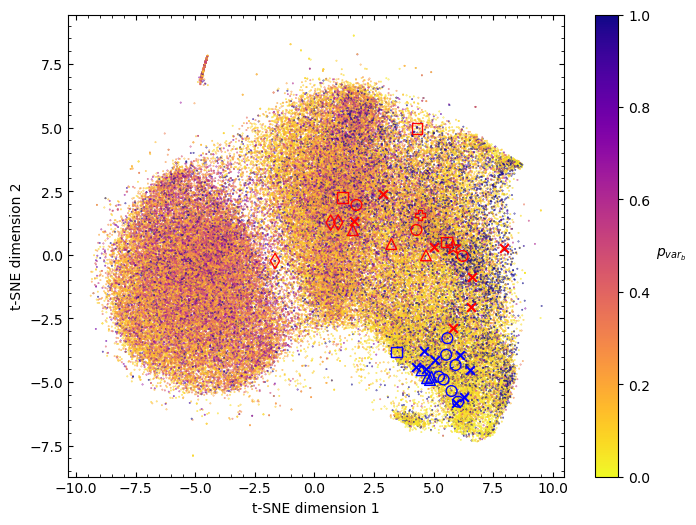

In [123]:
fig, axs = plt.subplots(figsize=(8, 6))
var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_label['var_prob_b'], s=0.1, cmap='plasma_r')
# var_b = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_label['hard_hs'], s=0.1, cmap='plasma_r')
axs.set_xlabel('t-SNE dimension 1')
axs.set_ylabel('t-SNE dimension 2')
axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)


tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez = df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares + flares_maybe)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva + dips_maybe)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

tsne_new = df_tsne.loc[df_tsne['obsreg_id'].isin(NEW)] 

markersize = 40
c_f = 'red'
c_d = 'blue'

axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(tsne_moredips['tsne1'], tsne_moredips['tsne2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Quirola et al. (2022)')
axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(tsne_nandra['tsne1'], tsne_nandra['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')


# axs.scatter(tsne_new['tsne1'], tsne_new['tsne2'], c='magenta', marker='X', s=markersize*5, facecolor='none', label='NEW')